# Importing Libraries

In [3]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance
from PnL_Computation import PnL
from Stock_Data import get_close
from Git import *

In [4]:
# %run "Git.ipynb".ipynb

In [5]:
git=GitHub(token,repo_owner,repo_name,branch)

# Importing Data

## Tickers

In [8]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [9]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [11]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [12]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [13]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [14]:
#trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))
price=Pnl_calculation.get_trade_in_usdt(trade_history)

In [15]:
book_cost=Pnl_calculation.get_book_cost(price)
realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,price)
historical_positions=Pnl_calculation.get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [16]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_93976\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [17]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [18]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()

In [19]:
holding=Binance.get_inventory()

In [20]:
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT').round(2)

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.94,2006.24,1.00,-131.89,-178.70,-310.59
BTCUSDT,601.02,965.69,0.48,3.54,364.67,368.21
SOLUSDT,281.20,311.84,0.16,0.00,30.64,30.64
JASMYUSDT,387.46,220.55,0.11,0.00,-166.91,-166.91
OMUSDT,526.32,181.24,0.09,0.00,-345.08,-345.08
ETHUSDT,250.75,176.15,0.09,0.00,-74.60,-74.60
TRXUSDT,76.87,131.93,0.07,-10.72,55.06,44.34
BBUSDT,60.18,17.69,0.01,-39.73,-42.48,-82.21
BNBUSDT,1.14,1.15,0.00,-10.61,0.00,-10.61
PEPEUSDT,0.00,0.00,0.00,-38.52,-0.00,-38.52


In [21]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining

42

In [22]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [23]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [24]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [25]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [26]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [27]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [29]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: 91e537388fd6f99801f2e7ca1d70c3863889de7a)
✅ File pushed/updated successfully!


In [30]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [31]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [32]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [33]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: 2da6df764ebae907b031ed0c3c79e590df515557)
✅ File pushed/updated successfully!


In [34]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [35]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [36]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [37]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [38]:
# pnl_history['Total']

In [39]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [40]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [41]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [42]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [43]:
pnl_history['Total']

2024-09-23   -242.846960
2024-09-24   -351.229838
2024-09-25   -362.331965
2024-09-26   -276.632747
2024-09-27   -260.113627
                 ...    
2025-05-21   -281.986065
2025-05-22   -220.474878
2025-05-23   -325.411242
2025-05-24   -306.952956
2025-05-25   -165.400623
Name: Total, Length: 245, dtype: float64

<Axes: >

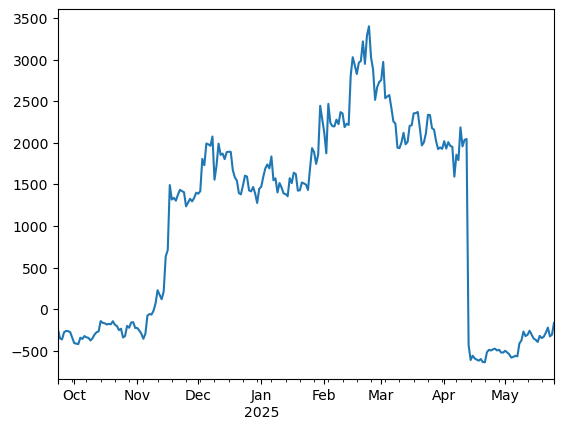

In [44]:
pnl_history['Total'].plot()

In [45]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl

2024-09-23           NaN
2024-09-24   -108.382879
2024-09-25    -11.102127
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2025-05-21     47.101514
2025-05-22     61.511187
2025-05-23   -104.936364
2025-05-24     18.458287
2025-05-25    141.552333
Name: Total, Length: 245, dtype: float64

In [46]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']
var_amount=np.nanpercentile(pnl_timeframe,1)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-409.581357299829, -1142.8435479265506)

In [47]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [48]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [49]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [50]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [51]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [52]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [53]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

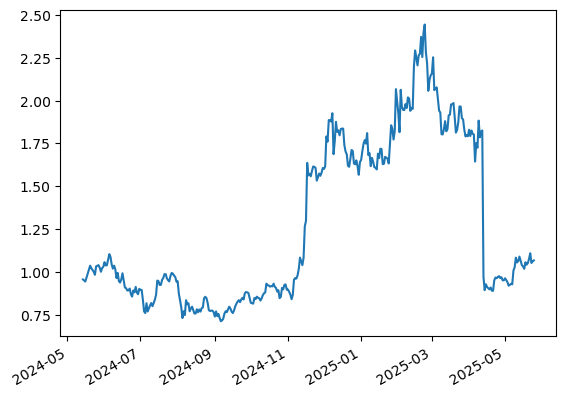

In [54]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()
plt.show()

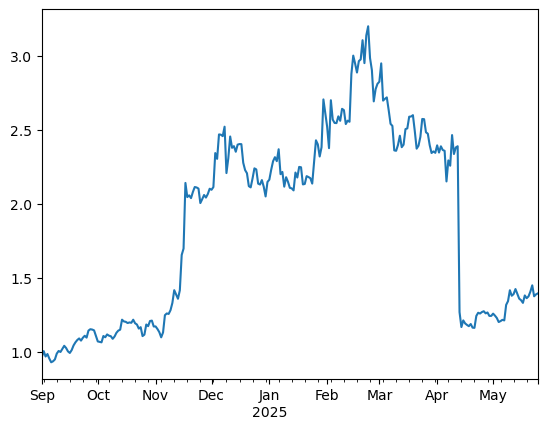

In [55]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()
plt.show()

## Ex ante data

In [57]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [60]:
days=0
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [61]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [64]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
PAXGUSDT,0.8088
BNBUSDT,0.0545
TRXUSDT,0.0379
PEPEUSDT,0.0225
SUIUSDT,0.0216
XRPUSDT,0.0192
OMUSDT,0.0177
BTCUSDT,0.0150
RAYUSDT,0.0030
WBTCUSDT,0.0000


In [65]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
PAXGUSDT,0.645145
BTCUSDT,0.300000
TRXUSDT,0.036839
OMUSDT,0.018016


In [66]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))
tickers_frontier.remove('BBUSDT')

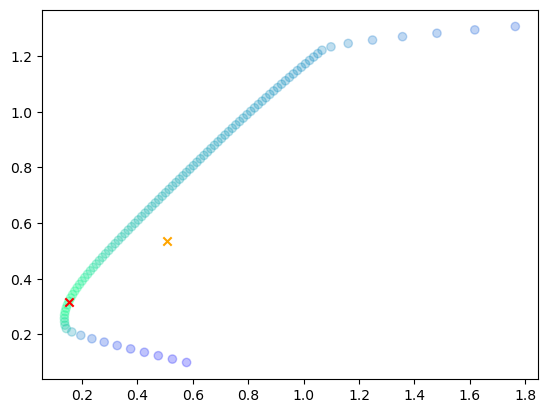

In [67]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()

In [68]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [69]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,965.687187,0.481342,0.0247,0.456642
SOLUSDT,311.841475,0.155436,0.0000,0.155436
JASMYUSDT,220.549627,0.109932,0.0000,0.109932
OMUSDT,181.244847,0.090341,0.0095,0.080841
ETHUSDT,176.145530,0.087799,0.0000,0.087799
TRXUSDT,131.928553,0.065759,0.0216,0.044159
BBUSDT,17.694654,0.008820,0.0000,0.008820
BNBUSDT,1.145762,0.000571,0.0624,-0.061829
PEPEUSDT,0.000003,0.000000,0.0259,-0.025900
PAXGUSDT,0.000000,0.000000,0.4000,-0.400000


### Current results

In [71]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [72]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
PAXGUSDT,0.835442
BTCUSDT,0.107859
TRXUSDT,0.056699


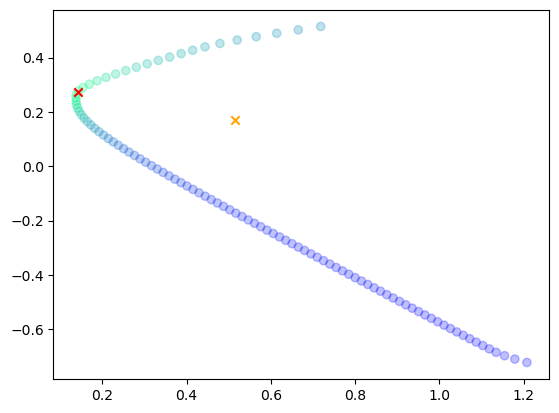

In [73]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()


In [74]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,965.687187,0.481342,0.107859,0.373483
SOLUSDT,311.841475,0.155436,0.000000,0.155436
JASMYUSDT,220.549627,0.109932,0.000000,0.109932
OMUSDT,181.244847,0.090341,0.000000,0.090341
ETHUSDT,176.145530,0.087799,0.000000,0.087799
TRXUSDT,131.928553,0.065759,0.056699,0.009060
BBUSDT,17.694654,0.008820,0.000000,0.008820
BNBUSDT,1.145762,0.000571,0.000000,0.000571
PEPEUSDT,0.000003,0.000000,0.000000,0.000000
PAXGUSDT,0.000000,0.000000,0.835442,-0.835442


# Risk Reward Analysis

In [76]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [77]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

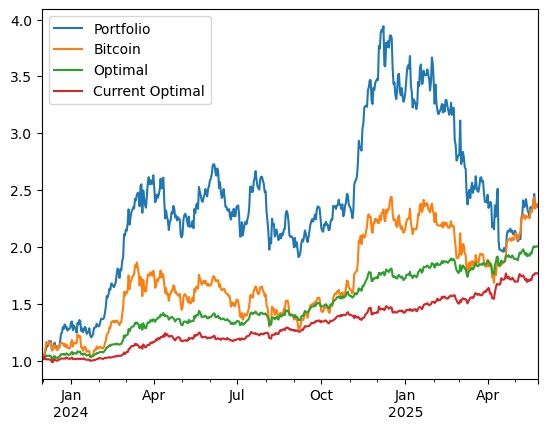

In [78]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()
plt.show()

In [79]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

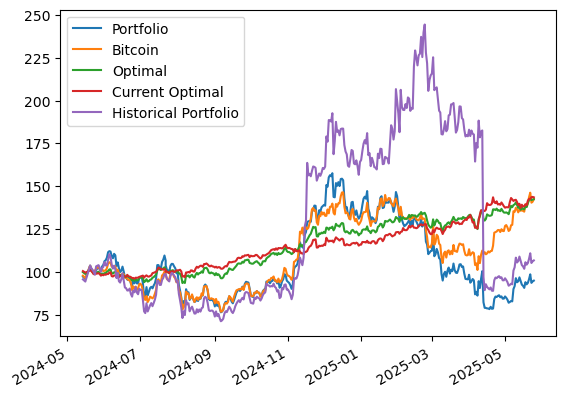

In [80]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()
plt.show()


In [81]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-05-16,91.856846,135.604778,136.648180,138.190913,103.171523
2025-05-17,90.656123,135.162040,136.536590,138.248362,101.801277
2025-05-18,93.995677,139.454457,138.473841,139.397981,105.631048
2025-05-19,92.728630,138.296184,137.812209,138.877207,104.209584
2025-05-20,93.562360,139.957982,140.153179,141.507573,105.152964
2025-05-21,95.746609,143.570686,141.918641,142.571773,107.631437
2025-05-22,98.580571,146.233077,142.541132,142.590936,110.847712
2025-05-23,93.578092,140.386153,141.920119,143.623537,105.192878
2025-05-24,94.428218,140.965256,142.234838,143.760242,106.168047
2025-05-25,94.887739,142.581009,142.375153,143.499331,106.681052


## Volatilities

In [83]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.179189
 dtype: float64,
 0.17935168871749185)

In [84]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.514762
 dtype: float64,
 0.5147621064547996)

In [85]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.508062
Bitcoin            0.427078
Optimal            0.179352
Current Optimal    0.139356
dtype: float64

In [86]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.5827052595103497

In [87]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

2.0847093755301462

In [88]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

0.33357388150668105

## Risk Contribution

In [90]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.413261,0.300000,0.465811,0.594043,0.510323,0.083719
OMUSDT,-0.313201,0.018016,-0.192777,0.065378,0.031399,0.033979
PAXGUSDT,0.400308,0.645145,0.682756,0.300177,0.261358,0.038819
TRXUSDT,0.030857,0.036839,0.044211,0.040402,0.016253,0.024149


In [91]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.057076,0.107859,0.114429,0.144591,0.097535,0.047056
TRXUSDT,0.031623,0.056699,0.061277,0.106623,0.082530,0.024093
PAXGUSDT,0.352668,0.835442,0.824294,0.748786,0.712030,0.036756


In [92]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.251487,0.475248,0.753367,0.331756,0.143613,0.188143
SOLUSDT,-0.032131,0.158416,0.130912,0.187714,0.049565,0.138149
JASMYUSDT,-0.065589,0.108911,0.044910,0.177409,0.052746,0.124664
OMUSDT,-0.188139,0.089109,-0.102659,0.167974,0.103346,0.064628
ETHUSDT,-0.030857,0.089109,0.060387,0.085591,0.011124,0.074467
TRXUSDT,0.038655,0.069307,0.111918,0.033698,0.009352,0.024346
BBUSDT,-0.008776,0.009901,0.001166,0.015858,0.000539,0.015319


# Value At Risk

## Historical

### Optimal Weights

In [96]:
var,cvar=historical_risk.historical_var(opt_weights,Q=1)
(var,cvar)

(-0.0315805317188617, -0.036996540610505176)

### Current Weights

In [98]:
var,cvar=current_risk.historical_var(current_weights,Q=1)
(var,cvar)

(-0.08591132003028153, -0.1194003381226449)

In [99]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.01
row=round(historical_var.shape[0]*centile)

In [100]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.029986
SOLUSDT     -0.020208
JASMYUSDT   -0.011616
OMUSDT      -0.008052
ETHUSDT     -0.011871
TRXUSDT     -0.002194
BBUSDT      -0.001810
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
PAXGUSDT    -0.000000
Portfolio   -0.085737
Name: 2025-04-06 00:00:00, dtype: float64

In [101]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.024624
SOLUSDT     -0.020438
JASMYUSDT   -0.013941
OMUSDT      -0.039180
ETHUSDT     -0.009108
TRXUSDT     -0.003697
BBUSDT      -0.001680
BNBUSDT      0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.112668
dtype: float64

## Parametric

### Optimal Weights

In [104]:
var,cvar=historical_risk.parametric_var(opt_weights,Q=0.99)

(var,cvar)

(-0.026283297930578247, -0.032553583826570455)

### Current Weights

In [106]:
var,cvar=current_risk.parametric_var(current_weights,Q=0.99)

(var,cvar)

(-0.07543640042684477, -0.09343291665133892)

## Multivariate

### Optimal Weights

In [109]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.024545193063180978, -0.02818125177063374)

### Current Weights

In [111]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.07330707496252227, -0.08401245170042466)

In [112]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

BTCUSDT     -0.024671
SOLUSDT     -0.014303
JASMYUSDT   -0.013487
OMUSDT      -0.012054
ETHUSDT     -0.006779
TRXUSDT     -0.002213
BBUSDT      -0.001281
Portfolio   -0.074789
dtype: float64

In [113]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

BTCUSDT     -0.024268
SOLUSDT     -0.014244
JASMYUSDT   -0.014217
OMUSDT      -0.012580
ETHUSDT     -0.006928
TRXUSDT     -0.002029
BBUSDT      -0.001406
Portfolio   -0.075674
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [117]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.02493605415156294, -0.029209801994011745)

### Current Weights

In [119]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.07356986513370868, -0.08405491812294494)

In [120]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [123]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.025353662625987025, -0.02912101253778013)

### Current Weights

In [125]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.07592894046424757, -0.08739669070068504)

In [126]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [129]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.05304654824696601, -0.06514227111408841)

### Current Weights

In [131]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.10501345803412285, -0.12886902714600462)

In [132]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [135]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [136]:
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.025948307658024156, -0.029503430745694746)

### Current Weights

In [138]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.07812794635206459, -0.08838906830289915)

In [139]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [140]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.027669,-0.024478,-0.018051,-0.024671,-0.025037
SOLUSDT,-0.007947,-0.014761,-0.010443,-0.014303,-0.014104
JASMYUSDT,-0.008372,-0.013254,-0.009091,-0.013487,-0.013567
OMUSDT,-0.019628,-0.011868,-0.010105,-0.012054,-0.013559
ETHUSDT,-0.002019,-0.006508,-0.004794,-0.006779,-0.006597
TRXUSDT,-0.001968,-0.002526,-0.001334,-0.002213,-0.002642
BBUSDT,-0.000103,-0.001228,-0.000876,-0.001281,-0.001259
Portfolio,-0.067706,-0.074623,-0.054695,-0.074789,-0.076766


In [141]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.025328,-0.024661,-0.017983,-0.024268,-0.024860
SOLUSDT,-0.007371,-0.015407,-0.010932,-0.014244,-0.013898
JASMYUSDT,-0.009422,-0.013320,-0.009709,-0.014217,-0.014035
OMUSDT,-0.021931,-0.011555,-0.009352,-0.012580,-0.013772
ETHUSDT,-0.001878,-0.006412,-0.004768,-0.006928,-0.006893
TRXUSDT,-0.002516,-0.002881,-0.001657,-0.002029,-0.002791
BBUSDT,-0.000001,-0.001296,-0.000827,-0.001406,-0.001341
Portfolio,-0.068447,-0.075533,-0.055227,-0.075674,-0.077590


## VaR Violation

In [143]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.021127,-0.021718,-0.021115,-0.008006
2024-01-15,-0.021127,-0.022108,-0.021514,0.010617
2024-01-16,-0.021127,-0.021929,-0.020301,-0.000807
2024-01-17,-0.021127,-0.021689,-0.021361,-0.007704
2024-01-18,-0.021127,-0.021966,-0.021519,-0.007499
...,...,...,...,...
2025-05-22,-0.014327,-0.021755,-0.019879,0.004386
2025-05-23,-0.014327,-0.021826,-0.020408,-0.004357
2025-05-24,-0.014327,-0.021732,-0.020328,0.002218
2025-05-25,-0.014327,-0.021284,-0.019396,0.000986


In [144]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.026420,-0.079184,-0.073784,-0.016576
2024-05-29,-0.020108,-0.076822,-0.068688,-0.009392
2024-05-30,-0.020108,-0.064180,-0.060447,0.027237
2024-05-31,-0.020108,-0.062878,-0.054560,0.009030
2024-06-01,-0.020108,-0.061651,-0.055934,0.020657
...,...,...,...,...
2025-05-22,-0.024626,-0.072945,-0.062784,0.029599
2025-05-23,-0.047127,-0.064806,-0.059855,-0.050745
2025-05-24,-0.047127,-0.064123,-0.062790,0.009085
2025-05-25,-0.047127,-0.056157,-0.056673,0.004866


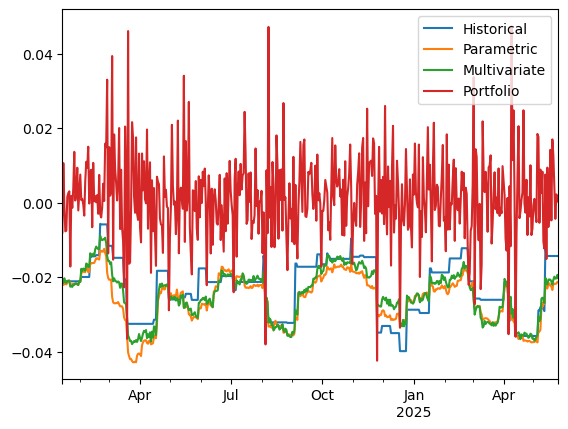

In [145]:
var_data.plot()
plt.show()

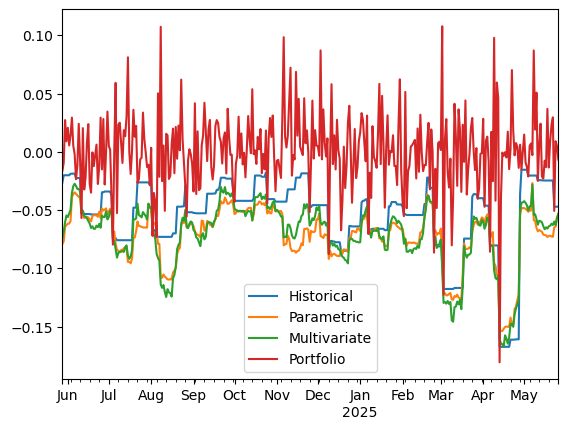

In [146]:
current_var_data.plot()
plt.show()


In [147]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.034068,0.018036,0.02004
Kupiec Stat,2.988129,14.077052,12.08082
P-value,0.083877,0.000175,0.000509


In [148]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.076923,0.021978,0.021978
Kupiec Stat,4.804238,7.546271,7.546271
P-value,0.02839,0.006013,0.006013


# Principal Component Analysis

## Historical PCA

In [151]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.76194202, 0.10225967, 0.05724223, 0.04147271, 0.03708337])

In [152]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.018841
ADAUSDT      0.019633
ALGOUSDT     0.020738
APTUSDT      0.018505
ARBUSDT      0.020837
ATOMUSDT     0.017719
AVAXUSDT     0.020640
BCHUSDT      0.016121
BNBUSDT      0.009158
BONKUSDT     0.026360
BTCUSDT      0.010368
CRVUSDT      0.021649
DOGEUSDT     0.020178
DOTUSDT      0.018447
ENSUSDT      0.022134
ETCUSDT      0.017093
ETHUSDT      0.015050
FDUSDUSDT    0.000071
FETUSDT      0.023997
FILUSDT      0.020287
FLOKIUSDT    0.025369
GRTUSDT      0.022479
HBARUSDT     0.019342
ICPUSDT      0.018472
IMXUSDT      0.021458
INJUSDT      0.022253
JASMYUSDT    0.022569
LDOUSDT      0.022467
LINKUSDT     0.018838
LTCUSDT      0.013873
MKRUSDT      0.014251
NEARUSDT     0.022747
NEXOUSDT     0.011846
OMUSDT       0.014577
OPUSDT       0.021404
PAXGUSDT     0.000138
PEPEUSDT     0.026532
QNTUSDT      0.015559
RAYUSDT      0.022250
SEIUSDT      0.022038
SHIBUSDT     0.019328
SOLUSDT      0.017619
STXUSDT      0.021853
SUIUSDT      0.019414
THETAUSDT    0.022857
TIAUSDT   

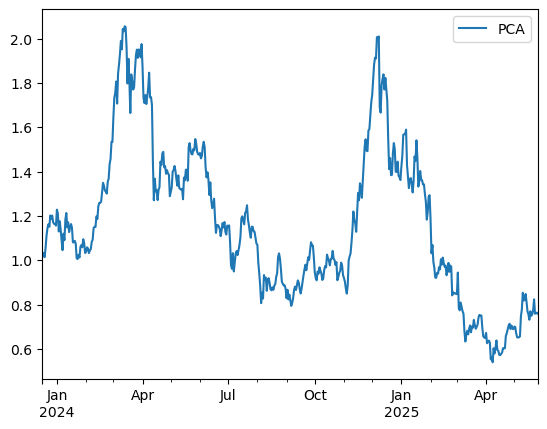

In [153]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()
plt.show()

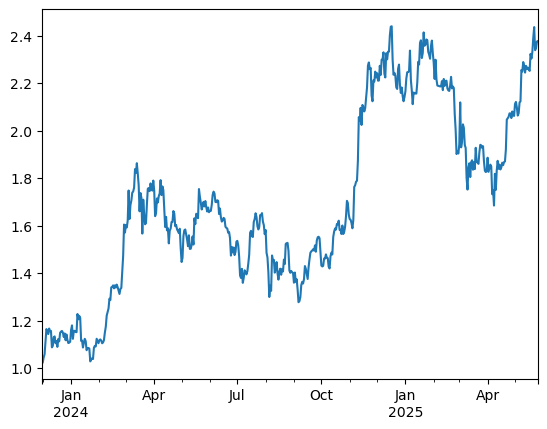

In [154]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [155]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
WBETHUSDT    0.474737
ETHUSDT      0.475618
ETCUSDT      0.502957
DOTUSDT      0.517306
ATOMUSDT     0.541692
NEXOUSDT     0.562576
AVAXUSDT     0.564056
WBTCUSDT     0.586943
FILUSDT      0.587313
BTCUSDT      0.587376
GRTUSDT      0.607440
ARBUSDT      0.607521
LINKUSDT     0.623259
VETUSDT      0.646680
ALGOUSDT     0.651746
SOLUSDT      0.659038
THETAUSDT    0.683214
DOGEUSDT     0.701981
IMXUSDT      0.703000
dtype: float64

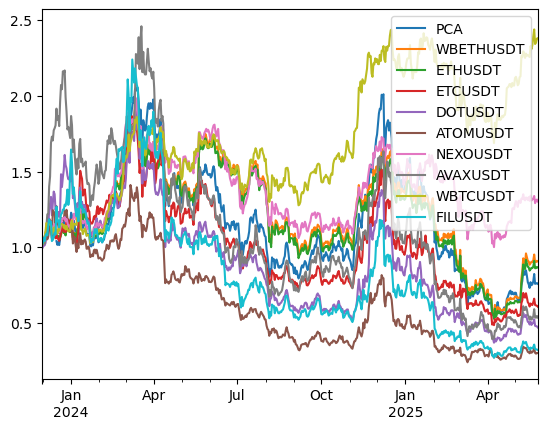

In [156]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()

<Axes: >

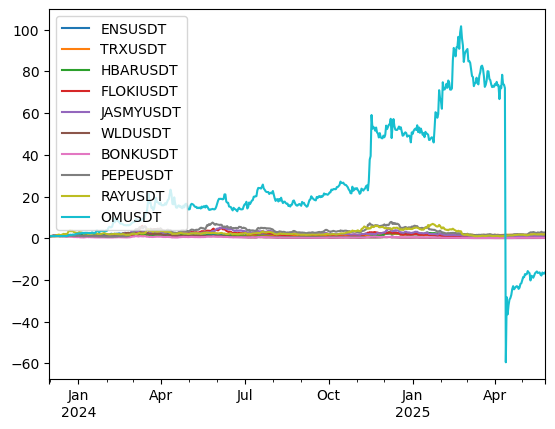

In [157]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [159]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.50419749, 0.31795766, 0.07279746, 0.06117948, 0.04386791])

In [160]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.050516
SOLUSDT      0.090836
JASMYUSDT    0.136816
OMUSDT       0.262966
ETHUSDT      0.077305
TRXUSDT      0.036296
BBUSDT       0.161788
BNBUSDT      0.050949
PEPEUSDT     0.131172
PAXGUSDT     0.001355
Name: PC1, dtype: float64

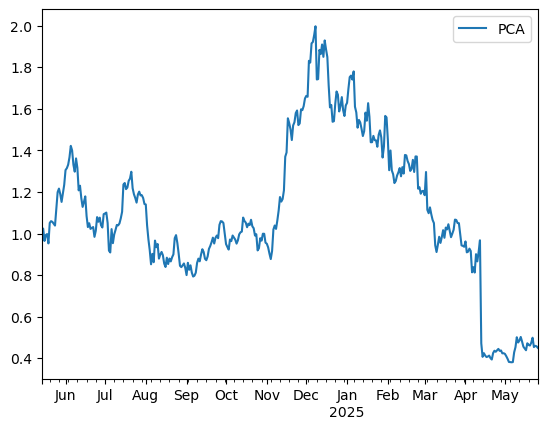

In [161]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()
plt.show()

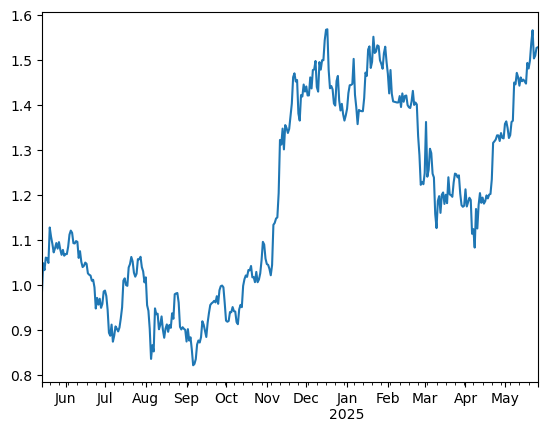

In [162]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [163]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.733573
BTCUSDT      0.763472
SOLUSDT      0.768851
BNBUSDT      0.773260
JASMYUSDT    0.987926
PAXGUSDT     0.998298
PEPEUSDT     1.027611
BBUSDT       1.035823
TRXUSDT      1.134726
dtype: float64

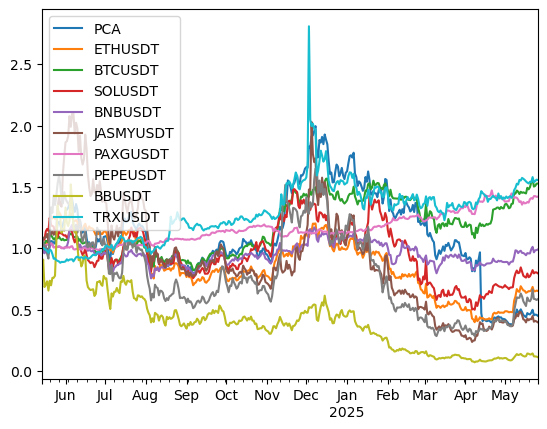

In [164]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()


## Sensitivity Analysis

In [166]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.897931
BBUSDT       1.604146
JASMYUSDT    1.430116
SOLUSDT      1.268647
ETHUSDT      1.074746
BTCUSDT      1.000000
OMUSDT       0.945347
BNBUSDT      0.657670
TRXUSDT      0.326416
PAXGUSDT     0.031248
Name: BTCUSDT, dtype: float64

In [167]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     3.347239
BBUSDT       2.859591
JASMYUSDT    2.033753
ETHUSDT      1.865864
OMUSDT       1.469948
SOLUSDT      1.342155
BTCUSDT      1.000000
BNBUSDT      0.692807
TRXUSDT      0.356980
PAXGUSDT    -0.045641
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [169]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [170]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BTCUSDT,0.354080
PAXGUSDT,0.262259
TRXUSDT,0.228770
JASMYUSDT,0.221059
ETHUSDT,0.190189
PEPEUSDT,0.127648
OMUSDT,0.121806
SOLUSDT,0.070365
BBUSDT,0.065020
BNBUSDT,-0.169662


### Regression to PCA

In [172]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.63057346806479

In [173]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.366505
BNBUSDT      1.208592
PCA          1.000000
ETHUSDT      0.979159
SOLUSDT      0.759618
JASMYUSDT    0.484935
PEPEUSDT     0.475990
BBUSDT       0.428944
TRXUSDT      0.292944
PAXGUSDT     0.291774
OMUSDT       0.102219
dtype: float64

In [174]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

TRXUSDT      2.056278
BTCUSDT      2.022287
BNBUSDT      1.586436
SOLUSDT      1.228836
PCA          1.000000
ETHUSDT      0.858901
JASMYUSDT    0.772203
PEPEUSDT     0.534836
BBUSDT       0.493881
OMUSDT       0.461020
PAXGUSDT    -0.734653
dtype: float64

### Correlation Matrix

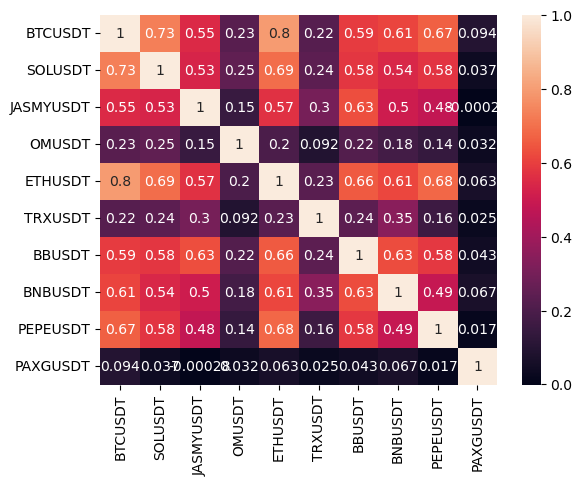

In [176]:
sns.heatmap(ex_ante_perf.corr(),annot=True)
plt.show()


<Axes: >

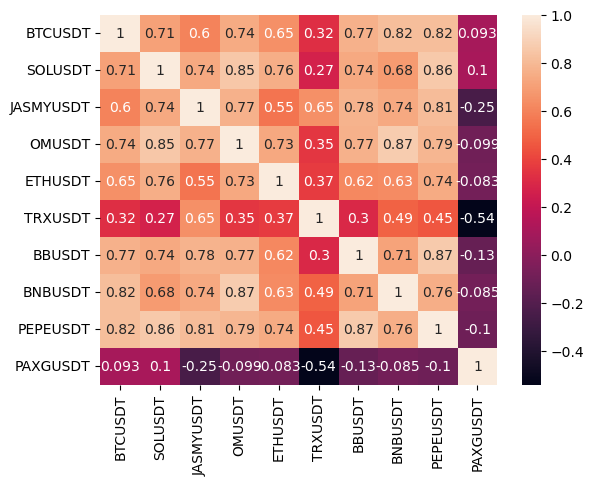

In [177]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

In [178]:
gold=get_close(['SPY','GOLD.PA'],start=start_date.strftime("%Y-%m-%d"),end=enddate.strftime("%Y-%m-%d")).dropna()
gold.index=pd.to_datetime(gold.index)
pct_change=gold.pct_change().sort_index()

In [179]:
correlation=pct_change['GOLD.PA'].rolling(30).corr(pct_change['SPY']).dropna()
beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['SPY']).dropna()/pct_change['SPY'].rolling(30).var().dropna())

<Axes: >

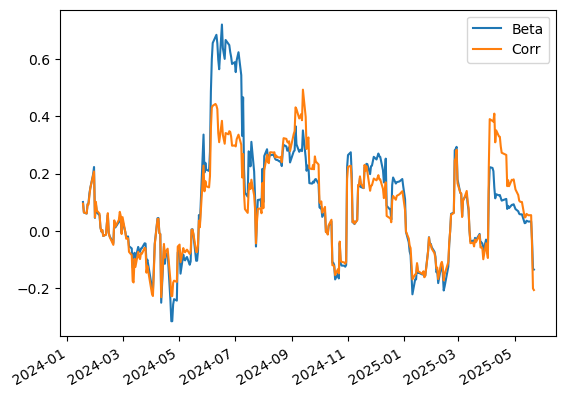

In [180]:
info=pd.DataFrame()
info['Beta']=beta
info['Corr']=correlation

info.plot()

## Sliding window optimization

In [182]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,SOLUSDT,JASMYUSDT,OMUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT,PAXGUSDT
2024-05-27,0.000000,0.000000,0.483880,0.000000,0.000000,0.000000,0.000000,0.000000,0.301117,0.215004
2024-06-10,0.000000,0.000000,0.150876,0.626168,0.000000,0.222957,0.000000,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.932091,0.000000,0.000000,0.000000,0.067909
2024-07-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.223616,0.003604,0.000000,0.000000,0.772780
2024-07-22,0.260704,0.086231,0.000000,0.019283,0.000000,0.238042,0.000000,0.000000,0.000000,0.395740
2024-08-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.453779,0.000000,0.000000,0.000000,0.546221
2024-09-02,0.000000,0.000000,0.000000,0.435186,0.000000,0.564814,0.000000,0.000000,0.000000,0.000000
2024-09-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-09-30,0.000000,0.000000,0.000000,0.176734,0.166022,0.526886,0.000000,0.000000,0.130357,0.000000


In [183]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,ZECUSDT
2024-10-18,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.256817,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2024-11-17,0.000000,0.000031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.006098,0.0,0.0,0.0,0.0,0.000000,0.000000,0.005028,0.000000,0.000000
2024-12-17,0.225845,0.018714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.032812,0.000000,0.000000,0.233640,0.000000
2025-01-16,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.073093,0.000000
2025-02-15,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2025-03-17,0.000000,0.753339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2025-04-16,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.127015,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2025-05-16,0.122774,0.006918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.018209,0.000000,0.000000,0.051821
2025-05-26,0.043971,0.010727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.127868


In [184]:
rolling_optimization.iloc[-1].sort_values(ascending=False)[:6]

PAXGUSDT    0.817433
ZECUSDT     0.127868
AAVEUSDT    0.043971
ADAUSDT     0.010727
APTUSDT     0.000000
STXUSDT     0.000000
Name: 2025-05-26 00:00:00, dtype: float64

In [185]:
git.create_or_replace_notebook("Prod.ipynb")

File 'Prod.ipynb' exists. Replacing the file...
✅ File 'Prod.ipynb' successfully pushed/updated to GitHub!
